# 3D Medical Image Preprocessing

## Install Necessary packages

Pytorch 1.9.0 currently not supported by medicaltorch

In [2]:
!pip install torch==1.3.0 torchvision==0.4.1
!pip install medicaltorch

     |████████████████████████████████| 773.1 MB 12 kB/s 
     |████████████████████████████████| 10.1 MB 59.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.3.0 which is incompatible.


## CHAOS T2SPIR

In [2]:
!unzip /content/drive/MyDrive/T2SPIR.zip

Archive:  /content/drive/MyDrive/T2SPIR.zip
   creating: T2SPIR/
   creating: T2SPIR/images/
  inflating: T2SPIR/images/image_15.nii.gz  
  inflating: T2SPIR/images/image_10.nii.gz  
  inflating: T2SPIR/images/image_13.nii.gz  
  inflating: T2SPIR/images/image_2.nii.gz  
  inflating: T2SPIR/images/image_19.nii.gz  
  inflating: T2SPIR/images/image_21.nii.gz  
  inflating: T2SPIR/images/image_20.nii.gz  
  inflating: T2SPIR/images/image_22.nii.gz  
  inflating: T2SPIR/images/image_3.nii.gz  
  inflating: T2SPIR/images/image_31.nii.gz  
  inflating: T2SPIR/images/image_32.nii.gz  
  inflating: T2SPIR/images/image_33.nii.gz  
  inflating: T2SPIR/images/image_38.nii.gz  
  inflating: T2SPIR/images/image_34.nii.gz  
  inflating: T2SPIR/images/image_36.nii.gz  
  inflating: T2SPIR/images/image_37.nii.gz  
  inflating: T2SPIR/images/image_39.nii.gz  
  inflating: T2SPIR/images/image_8.nii.gz  
  inflating: T2SPIR/images/image_5.nii.gz  
  inflating: T2SPIR/images/image_1.nii.gz  
   creating:

In [1]:
import torch
torch.__version__

'1.3.0'

## Data Visualization


(256, 256)
(256, 256)


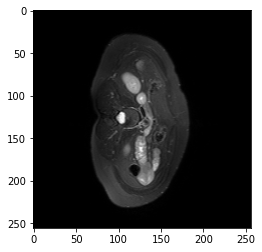

In [10]:
from collections import defaultdict
import time
import os

import numpy as np

from tqdm import tqdm

#from tensorboardX import SummaryWriter

from medicaltorch import datasets as mt_datasets
from medicaltorch import models as mt_models
from medicaltorch import transforms as mt_transforms
from medicaltorch import losses as mt_losses
from medicaltorch import metrics as mt_metrics
from medicaltorch import filters as mt_filters

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import autograd, optim
import torch.backends.cudnn as cudnn
import torch.nn as nn

import torchvision.utils as vutils
import matplotlib.pyplot as plt

cudnn.benchmark = True


ROOT_DIR_GMCHALLENGE = "/content/T2SPIR/"
mri_input_filename = os.path.join(ROOT_DIR_GMCHALLENGE,
                                          'images/image_10.nii.gz')
mri_gt_filename = os.path.join(ROOT_DIR_GMCHALLENGE,
                                       'labels/label_10.nii.gz')


pair = mt_datasets.SegmentationPair2D(mri_input_filename,mri_gt_filename)

slice_pair = pair.get_pair_slice(10)   ## Slice Number

input_slice = slice_pair["input"]
print(input_slice.shape)
gt_slice = slice_pair["gt"]
print(gt_slice.shape)

img = input_slice
plt.imshow(img,cmap='gray')
plt.show()

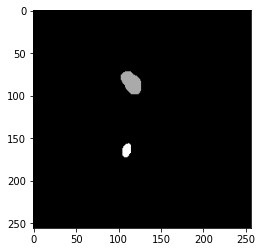

In [11]:
img = gt_slice
plt.imshow(img,cmap='gray')
plt.show()

In [21]:
img_data,seg_data = pair.get_pair_data()
print(img_data.shape)
print(seg_data.shape)

(256, 256, 36)
(256, 256, 36)


In [31]:
img_list = os.listdir(os.path.join(ROOT_DIR_GMCHALLENGE,'images'))
label_list = os.listdir(os.path.join(ROOT_DIR_GMCHALLENGE,'labels'))

In [32]:
filename_pairs = [(os.path.join(ROOT_DIR_GMCHALLENGE,'images',x),os.path.join(ROOT_DIR_GMCHALLENGE,'labels',y)) for x,y in zip(img_list,label_list)]

In [35]:
filename_pairs.sort()

In [60]:
filename_pairs

[('/content/T2SPIR/images/image_1.nii.gz',
  '/content/T2SPIR/labels/label_19.nii.gz'),
 ('/content/T2SPIR/images/image_10.nii.gz',
  '/content/T2SPIR/labels/label_8.nii.gz'),
 ('/content/T2SPIR/images/image_13.nii.gz',
  '/content/T2SPIR/labels/label_13.nii.gz'),
 ('/content/T2SPIR/images/image_15.nii.gz',
  '/content/T2SPIR/labels/label_3.nii.gz'),
 ('/content/T2SPIR/images/image_19.nii.gz',
  '/content/T2SPIR/labels/label_36.nii.gz'),
 ('/content/T2SPIR/images/image_2.nii.gz',
  '/content/T2SPIR/labels/label_10.nii.gz'),
 ('/content/T2SPIR/images/image_20.nii.gz',
  '/content/T2SPIR/labels/label_31.nii.gz'),
 ('/content/T2SPIR/images/image_21.nii.gz',
  '/content/T2SPIR/labels/label_21.nii.gz'),
 ('/content/T2SPIR/images/image_22.nii.gz',
  '/content/T2SPIR/labels/label_38.nii.gz'),
 ('/content/T2SPIR/images/image_3.nii.gz',
  '/content/T2SPIR/labels/label_1.nii.gz'),
 ('/content/T2SPIR/images/image_31.nii.gz',
  '/content/T2SPIR/labels/label_15.nii.gz'),
 ('/content/T2SPIR/images/i

## Arrange image and gt in a pair (tuple)

In [61]:
filename_pairs = [
                  ('/content/T2SPIR/images/image_1.nii.gz','/content/T2SPIR/labels/label_1.nii.gz'),
                  ('/content/T2SPIR/images/image_2.nii.gz','/content/T2SPIR/labels/label_2.nii.gz'),
                  ('/content/T2SPIR/images/image_3.nii.gz','/content/T2SPIR/labels/label_3.nii.gz'),
                  ('/content/T2SPIR/images/image_5.nii.gz','/content/T2SPIR/labels/label_5.nii.gz'),
                  ('/content/T2SPIR/images/image_8.nii.gz','/content/T2SPIR/labels/label_8.nii.gz'),
                  ('/content/T2SPIR/images/image_10.nii.gz','/content/T2SPIR/labels/label_10.nii.gz'),
                  ('/content/T2SPIR/images/image_13.nii.gz','/content/T2SPIR/labels/label_13.nii.gz'),
                  ('/content/T2SPIR/images/image_15.nii.gz','/content/T2SPIR/labels/label_15.nii.gz'),
                  ('/content/T2SPIR/images/image_19.nii.gz','/content/T2SPIR/labels/label_19.nii.gz'),
                  ('/content/T2SPIR/images/image_20.nii.gz','/content/T2SPIR/labels/label_20.nii.gz'),
                  ('/content/T2SPIR/images/image_21.nii.gz','/content/T2SPIR/labels/label_21.nii.gz'),
                  ('/content/T2SPIR/images/image_22.nii.gz','/content/T2SPIR/labels/label_22.nii.gz'),
                  ('/content/T2SPIR/images/image_31.nii.gz','/content/T2SPIR/labels/label_31.nii.gz'),
                  ('/content/T2SPIR/images/image_32.nii.gz','/content/T2SPIR/labels/label_32.nii.gz'),
                  ('/content/T2SPIR/images/image_33.nii.gz','/content/T2SPIR/labels/label_33.nii.gz'),
                  ('/content/T2SPIR/images/image_34.nii.gz','/content/T2SPIR/labels/label_34.nii.gz'),
                  ('/content/T2SPIR/images/image_36.nii.gz','/content/T2SPIR/labels/label_36.nii.gz'),
                  ('/content/T2SPIR/images/image_37.nii.gz','/content/T2SPIR/labels/label_37.nii.gz'),
                  ('/content/T2SPIR/images/image_38.nii.gz','/content/T2SPIR/labels/label_38.nii.gz'),
                  ('/content/T2SPIR/images/image_39.nii.gz','/content/T2SPIR/labels/label_39.nii.gz'),


                  
]

In [62]:
filename_pairs

[('/content/T2SPIR/images/image_1.nii.gz',
  '/content/T2SPIR/labels/label_1.nii.gz'),
 ('/content/T2SPIR/images/image_2.nii.gz',
  '/content/T2SPIR/labels/label_2.nii.gz'),
 ('/content/T2SPIR/images/image_3.nii.gz',
  '/content/T2SPIR/labels/label_3.nii.gz'),
 ('/content/T2SPIR/images/image_5.nii.gz',
  '/content/T2SPIR/labels/label_5.nii.gz'),
 ('/content/T2SPIR/images/image_8.nii.gz',
  '/content/T2SPIR/labels/label_8.nii.gz'),
 ('/content/T2SPIR/images/image_10.nii.gz',
  '/content/T2SPIR/labels/label_10.nii.gz'),
 ('/content/T2SPIR/images/image_13.nii.gz',
  '/content/T2SPIR/labels/label_13.nii.gz'),
 ('/content/T2SPIR/images/image_15.nii.gz',
  '/content/T2SPIR/labels/label_15.nii.gz'),
 ('/content/T2SPIR/images/image_19.nii.gz',
  '/content/T2SPIR/labels/label_19.nii.gz'),
 ('/content/T2SPIR/images/image_20.nii.gz',
  '/content/T2SPIR/labels/label_20.nii.gz'),
 ('/content/T2SPIR/images/image_21.nii.gz',
  '/content/T2SPIR/labels/label_21.nii.gz'),
 ('/content/T2SPIR/images/image

In [63]:
composed_transform = transforms.Compose([
            mt_transforms.Resample(0.25, 0.25),
            mt_transforms.CenterCrop2D((224, 224)),
            mt_transforms.ToTensor(),
])


In [78]:

train_dataset = mt_datasets.MRI2DSegmentationDataset(filename_pairs,transform=mt_transforms.ToTensor())

In [79]:
print(type(train_dataset))

<class 'medicaltorch.datasets.MRI2DSegmentationDataset'>


In [80]:
print(len(train_dataset))

623


In [81]:
train_dataset[0]  ## individiual elements of the dataset

{'gt': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'gt_metadata': <medicaltorch.datasets.SampleMetadata at 0x7f2479db6590>,
 'input': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'input_metadata': <medicaltorch.datasets.SampleMetadata at 0x7f2475bd8550>}

In [82]:
# PyTorch data loader
dataloader = DataLoader(train_dataset, batch_size=2,collate_fn=mt_datasets.mt_collate)
batch = next(iter(dataloader))

In [83]:
batch

{'gt': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'gt_metadata': [<medicaltorch.datasets.SampleMetadata at 0x7f2475d3fa90>,
 'input': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ...,

In [84]:
batch['input'].size()
batch['gt'].size()

torch.Size([2, 1, 256, 256])

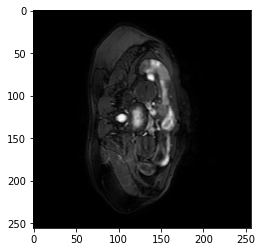

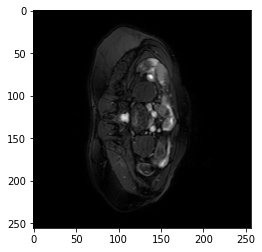

In [85]:
for item in batch['input']:
    plt.imshow(item.squeeze(0),cmap = 'gray')
    plt.show()

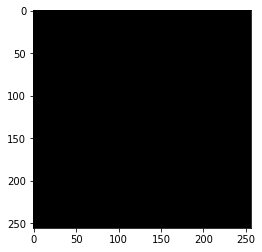

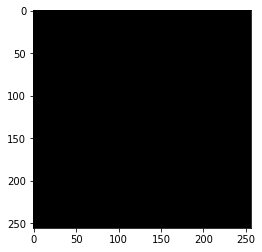

In [86]:
for item in batch['gt']:
    plt.imshow(item.squeeze(0),cmap = 'gray')
    plt.show()

## Using built-in Transformations

In [88]:
train_transform = transforms.Compose([
        mt_transforms.Resample(0.25, 0.25),
        mt_transforms.ElasticTransform(alpha_range=(40.0, 60.0),
                                       sigma_range=(2.5, 4.0),
                                       p=0.3),
        mt_transforms.ToTensor()]
)

In [89]:
train_dataset = mt_datasets.MRI2DSegmentationDataset(filename_pairs,transform=train_transform)

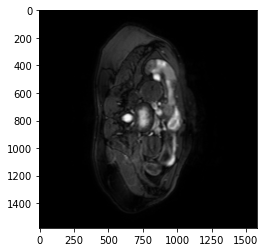

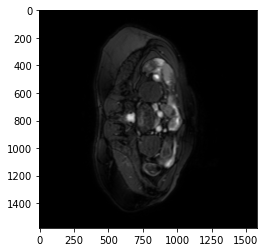

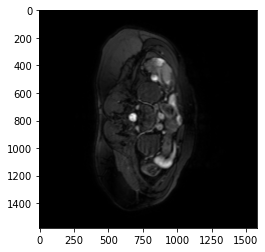

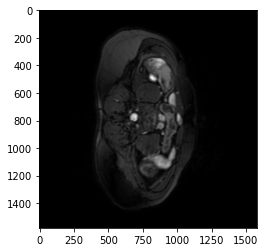

In [91]:
dataloader = DataLoader(train_dataset, batch_size=4,collate_fn=mt_datasets.mt_collate)
batch = next(iter(dataloader))
for item in batch['input']:
    plt.imshow(item.squeeze(0),cmap = 'gray')
    plt.show()

### For further reading: https://medium.com/dair-ai/medical-imaging-analysis-mri-cnn-pytorch-4877e64e7303